In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.keras import TqdmCallback

In [3]:
import matplotlib as mpl
mpl.rc("font", family="Times New Roman", size=18)

In [8]:
import sys
sys.path.append("../NES")

In [12]:
import NES.misc as mc
from NES.NeuralEikonalSolver import NES_OP
from NES.eikonalLayers import IsoEikonal

from ray_tracing import nes_op_tracing

## Velocity model

In [13]:
def vel_func(r):
    
    if len(np.shape(r)) > 1:   
        
        return 1700 + 0.5 * r[..., - 1]
    
    else:
        
        return 1700 + 0.5 * r[- 1]

In [33]:
nx, nz = 201, 201

x = np.linspace(- 2000, 2000, nx)
z = np.linspace(- 2000, 2000, nz)

xx, zz = np.meshgrid(x, z, indexing="ij")
grid_points = np.reshape(np.stack([xx, zz], axis=- 1), [nx * nz, 2])

vel = np.reshape(vel_func(grid_points), [nx, nz])

source = np.array([0, 1800])

## Network training

In [21]:
# Velocity model interpolator:
eik_vel = mc.Interpolator(vel_1, x, z)

# Initialization
eikonal = IsoEikonal(p=2, hamiltonian=True)

Eik = NES_OP(xs=source, 
             velocity=eik_vel,
             eikonal=eikonal)

# Build neural-network model
Eik.build_model(nl=4,
                nu=50,
                act="lad-gauss-1",
                out_act="lad-sigmoid-1",
                factored=True,
                input_scale=True,
                out_vscale=True,
                kernel_initializer="he_normal")

Eik.compile(loss="mae", lr=0.003, decay=0.0005)

# Training
history = Eik.train(x_train=grid_points,
                    verbose=0, 
                    epochs=3000,
                    batch_size=len(grid_points) // 4,
                    callbacks=[TqdmCallback(verbose=0)])

## Ray tracing

In [23]:
# Receivers:
recs_x = np.linspace(- 1800, 1800, 51)
recs_z = np.zeros_like(recs_x)

recs = np.transpose([recs_x, recs_z])

In [24]:
# Desired number of ray points:
num_points = 101

In [31]:
# Rays:
rays = np.empty([len(recs), num_points, 2])

for i, rec in enumerate(tqdm(recs)):
    
    rays[i] = nes_op_tracing(rec,
                             num_points,
                             Eik,
                             solver="specified steps",
                             direction="backward",
                             target_front=0.001,
                             vel_func=vel_func)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [13:59<00:00, 16.45s/it]


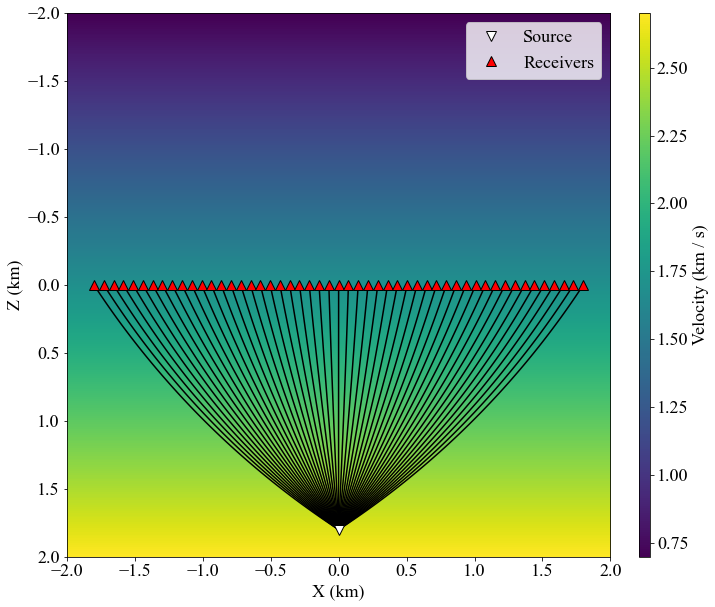

In [35]:
fig_model, ax_model = plt.subplots(figsize=[10, 10])

im = ax_model.imshow(np.transpose(vel) / 1000,
                     extent=np.array([x[0], x[- 1], z[0], z[- 1]]) / 1000,
                     origin="lower",
                     cmap="viridis")

for ray in rays:
    
    ax_model.plot(ray[:, 0] / 1000, ray[:, 1] / 1000, "k-")
    

ax_model.plot([source[0] / 1000], [source[1] / 1000], "wv", markersize=10, markeredgecolor="k", label="Source")
ax_model.plot(recs_x / 1000, recs_z / 1000, "r^", markersize=10, markeredgecolor="k", label="Receivers")
    
ax_model.invert_yaxis() 

ax_model.set_xlabel("X (km)")
ax_model.set_ylabel("Z (km)")

ax_model.legend()

cax = fig_model.add_axes([ax_model.get_position().x1 + 0.04,
                          ax_model.get_position().y0,
                          0.015,
                          ax_model.get_position().y1 - ax_model.get_position().y0])
   
fig_model.colorbar(im, cax=cax, label="Velocity (km / s)")


plt.show()